## Setup

In [50]:
import azureml.core
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.43.0 to work with azureml_edsp


In [51]:
import pyspark.pandas as ps
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

In [52]:
spark = SparkSession \
        .builder \
        .appName('Employee Retention') \
        .getOrCreate()

In [53]:
# Load data
data = spark.read.csv('data/Sample_IssueDataset.csv', \
                      header="true", \
                      inferSchema="true")

# Temporarily convert to pandas-on-spark DataFrame for
# better appearance and print a sample of rows
data.pandas_api().sample(frac=0.0002, random_state=135)

,Activity on Company Forums,EmployeeLeft,Hired through SMTP,National Origin (code),Negative Review in Past 5 Years,"Survey, Relative, Attitude toward Peers","Survey, Relative, Peer's Average Attitude toward Environment","Survey, Relative, Peer's Average Attitude toward Resources","Survey, Relative, Peer's Average Attitude toward WorkType","Survey, Relative, Peer's Average Attitude toward Workload","Survey, Relative, Peer's Average Review of Employee",University
3949,37.0,0.0,0,4,1,3,3,5,1,2,1,Smolensk Humanitarian University
6814,32.0,1.0,0,6,1,2,3,5,3,4,4,Universitas Pasundan
9153,45.0,1.0,0,3,0,1,2,1,1,5,6,University of Commerce Luigi Bocconi


In [54]:
data.printSchema()

root
 |-- Activity on Company Forums: double (nullable = true)
 |-- EmployeeLeft: double (nullable = true)
 |-- Hired through SMTP: integer (nullable = true)
 |-- National Origin (code): integer (nullable = true)
 |-- Negative Review in Past 5 Years: integer (nullable = true)
 |-- Survey, Relative, Attitude toward Peers: integer (nullable = true)
 |-- Survey, Relative, Peer's Average Attitude toward Environment: integer (nullable = true)
 |-- Survey, Relative, Peer's Average Attitude toward Resources: integer (nullable = true)
 |-- Survey, Relative, Peer's Average Attitude toward WorkType: integer (nullable = true)
 |-- Survey, Relative, Peer's Average Attitude toward Workload: integer (nullable = true)
 |-- Survey, Relative, Peer's Average Review of Employee: integer (nullable = true)
 |-- University: string (nullable = true)



In [55]:
data.select("University").distinct().show()

+--------------------+
|          University|
+--------------------+
|Universitas Neger...|
|Kyrgyz National U...|
|  Americanos College|
|     Rice University|
|Universitas Pasundan|
|University of Com...|
|Smolensk Humanita...|
+--------------------+



In [56]:
train_df, test_df = data.randomSplit([0.8, 0.2], seed=123)

## Handle categorical feature(s)

For decision tree and random forests, we should _not_ one-hot-encode our variables. Categorical features may end up taking a back seat relative to the continuous features. 

In [57]:
# Return all column names and their data types as a list
train_df.dtypes

[('Activity on Company Forums', 'double'),
 ('EmployeeLeft', 'double'),
 ('Hired through SMTP', 'int'),
 ('National Origin (code)', 'int'),
 ('Negative Review in Past 5 Years', 'int'),
 ('Survey, Relative, Attitude toward Peers', 'int'),
 ("Survey, Relative, Peer's Average Attitude toward Environment", 'int'),
 ("Survey, Relative, Peer's Average Attitude toward Resources", 'int'),
 ("Survey, Relative, Peer's Average Attitude toward WorkType", 'int'),
 ("Survey, Relative, Peer's Average Attitude toward Workload", 'int'),
 ("Survey, Relative, Peer's Average Review of Employee", 'int'),
 ('University', 'string')]

In [58]:
# Identify and store fields which are of type "string"
categorical_cols = [field for (field, dataType) in train_df.dtypes if dataType=="string"]
categorical_cols

['University']

In [59]:
# Append "Index" to the string-type column name(s)
index_output_cols = [x + "Index" for x in categorical_cols]
index_output_cols

['UniversityIndex']

In [60]:
from pyspark.ml.feature import StringIndexer

string_indexer = StringIndexer(inputCols=categorical_cols, outputCols=index_output_cols, handleInvalid="skip")

Combine the numeric and indexed categorical columns.

In [61]:
# Filter only for numeric columns and exlude our label, "EmployeeLeft"
numeric_cols = [field for (field, dataType) in train_df.dtypes if ((dataType=="double" or dataType=="int") & (field != "EmployeeLeft"))]
numeric_cols

['Activity on Company Forums',
 'Hired through SMTP',
 'National Origin (code)',
 'Negative Review in Past 5 Years',
 'Survey, Relative, Attitude toward Peers',
 "Survey, Relative, Peer's Average Attitude toward Environment",
 "Survey, Relative, Peer's Average Attitude toward Resources",
 "Survey, Relative, Peer's Average Attitude toward WorkType",
 "Survey, Relative, Peer's Average Attitude toward Workload",
 "Survey, Relative, Peer's Average Review of Employee"]

In [62]:
# Combine StringIndexer output with the numeric columns
assembler_inputs = index_output_cols + numeric_cols
assembler_inputs

['UniversityIndex',
 'Activity on Company Forums',
 'Hired through SMTP',
 'National Origin (code)',
 'Negative Review in Past 5 Years',
 'Survey, Relative, Attitude toward Peers',
 "Survey, Relative, Peer's Average Attitude toward Environment",
 "Survey, Relative, Peer's Average Attitude toward Resources",
 "Survey, Relative, Peer's Average Attitude toward WorkType",
 "Survey, Relative, Peer's Average Attitude toward Workload",
 "Survey, Relative, Peer's Average Review of Employee"]

In [63]:
from pyspark.ml.feature import VectorAssembler

# Combine all numeric and categorical inputs
vec_assembler = VectorAssembler(inputCols = assembler_inputs, outputCol="features")

## Building the decision tree with DecisionTreeClassifier and default parameters

In [73]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="EmployeeLeft")

## Fit our pipeline

In [74]:
from pyspark.ml import Pipeline

# Combine stages into a pipeline
stages = [string_indexer, vec_assembler, dt]
pipeline = Pipeline(stages=stages)

In [75]:
# Perform the fit
pipeline_model = pipeline.fit(train_df)

## Retrieve fitted decision tree model and observe feature importance scores

In [76]:
dt_model = pipeline_model.stages[-1]
dt_model

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_42a7b1895c78, depth=5, numNodes=43, numClasses=2, numFeatures=11

In [77]:
dt_model.featureImportances

SparseVector(11, {0: 0.0011, 3: 0.3658, 5: 0.1062, 6: 0.34, 8: 0.1869})

## Interpret feature importances

In [78]:
import pandas as pd

features_df = pd.DataFrame(list(zip(vec_assembler.getInputCols(), dt_model.featureImportances)), columns=["feature", "importance"])
features_df

,feature,importance
0,UniversityIndex,0.001089
1,Activity on Company Forums,0.000000
2,Hired through SMTP,0.000000
3,National Origin (code),0.365821
4,Negative Review in Past 5 Years,0.000000
5,"Survey, Relative, Attitude toward Peers",0.106237
6,"Survey, Relative, Peer's Average Attitude towa...",0.339959
7,"Survey, Relative, Peer's Average Attitude towa...",0.000000
8,"Survey, Relative, Peer's Average Attitude towa...",0.186894
9,"Survey, Relative, Peer's Average Attitude towa...",0.000000


In [79]:
features_df.sort_values("importance", ascending=False)

,feature,importance
3,National Origin (code),0.365821
6,"Survey, Relative, Peer's Average Attitude towa...",0.339959
8,"Survey, Relative, Peer's Average Attitude towa...",0.186894
5,"Survey, Relative, Attitude toward Peers",0.106237
0,UniversityIndex,0.001089
1,Activity on Company Forums,0.000000
2,Hired through SMTP,0.000000
4,Negative Review in Past 5 Years,0.000000
7,"Survey, Relative, Peer's Average Attitude towa...",0.000000
9,"Survey, Relative, Peer's Average Attitude towa...",0.000000


## Apply our model to a test set

In [83]:
pred_df = pipeline_model.transform(test_df)
pred_df

DataFrame[Activity on Company Forums: double, EmployeeLeft: double, Hired through SMTP: int, National Origin (code): int, Negative Review in Past 5 Years: int, Survey, Relative, Attitude toward Peers: int, Survey, Relative, Peer's Average Attitude toward Environment: int, Survey, Relative, Peer's Average Attitude toward Resources: int, Survey, Relative, Peer's Average Attitude toward WorkType: int, Survey, Relative, Peer's Average Attitude toward Workload: int, Survey, Relative, Peer's Average Review of Employee: int, University: string, UniversityIndex: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [81]:
pred_df.select("features", "EmployeeLeft", "prediction").orderBy("EmployeeLeft", ascending=False).show()

+--------------------+------------+----------+
|            features|EmployeeLeft|prediction|
+--------------------+------------+----------+
|[1.0,13.0,0.0,4.0...|         1.0|       1.0|
|[1.0,15.0,1.0,4.0...|         1.0|       1.0|
|[6.0,13.0,0.0,4.0...|         1.0|       0.0|
|[0.0,6.0,0.0,2.0,...|         1.0|       0.0|
|[1.0,13.0,1.0,5.0...|         1.0|       1.0|
|[2.0,14.0,1.0,3.0...|         1.0|       1.0|
|[5.0,15.0,1.0,4.0...|         1.0|       1.0|
|[2.0,14.0,1.0,3.0...|         1.0|       1.0|
|[2.0,9.0,1.0,4.0,...|         1.0|       1.0|
|[0.0,14.0,1.0,4.0...|         1.0|       1.0|
|[0.0,10.0,1.0,6.0...|         1.0|       1.0|
|[5.0,15.0,0.0,3.0...|         1.0|       0.0|
|[2.0,11.0,1.0,3.0...|         1.0|       0.0|
|[2.0,15.0,0.0,4.0...|         1.0|       1.0|
|[1.0,12.0,1.0,6.0...|         1.0|       1.0|
|[5.0,15.0,0.0,4.0...|         1.0|       0.0|
|[1.0,13.0,0.0,4.0...|         1.0|       0.0|
|[3.0,15.0,0.0,4.0...|         1.0|       1.0|
|[2.0,13.0,1.

In [85]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator=MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="EmployeeLeft")
acc = evaluator.evaluate(pred_df)
 
print("Prediction accuracy: ", acc)

Prediction accuracy:  0.6758899921093504


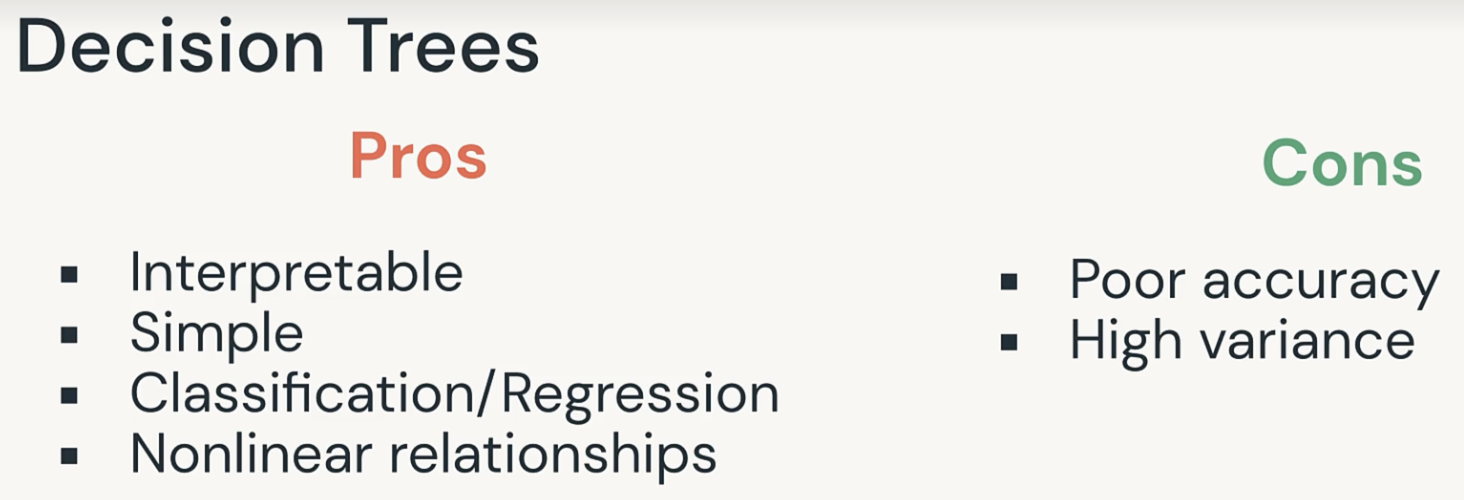

# Random forests